<a href="https://colab.research.google.com/github/g8428/TIL/blob/master/220304_nlp_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

train_images = train_images/255.
test_images = test_images/255.

valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.15, shuffle=True)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

class ConvBNRelu(Model):
    def __init__(self, filters, kernel_size=3, strides=(1, 1), padding='same'):
        super(ConvBNRelu, self).__init__()
        self.conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                           padding=padding, kernel_initializer='glorot_normal')
        
        self.batchnorm = BatchNormalization()

    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)

        return layer


In [4]:
class DenseBNRelu(Model):
    def __init__(self, units):
        super(DenseBNRelu, self).__init__()
        self.dense = Dense(units=units, kernel_initializer='glorot_normal')
        self.batchnorm = BatchNormalization()

    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)

        return layer

In [5]:
class MNISTModel(Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = ConvBNRelu(filters=32, kernel_size=(3, 3), padding='valid')
        self.pool1 = MaxPool2D()
        self.conv2 = ConvBNRelu(filters=64, kernel_size=(3, 3), padding='valid')
        self.pool2 = MaxPool2D()
        self.conv3 = ConvBNRelu(filters=64, kernel_size=(3, 3), padding='valid')
        self.flat = Flatten()
        self.dense4 = DenseBNRelu(units=64)
        self.drop = Dropout(0.2)
        self.outputs = Dense(10, activation='softmax')

    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.flat(net)
        net = self.dense4(net)
        net = self.drop(net)
        net = self.outputs(net)

        return net


In [6]:
model = MNISTModel()
model(Input(shape=(28, 28, 1)))
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn_relu (ConvBNRelu)   multiple                  448       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv_bn_relu_1 (ConvBNRelu)  multiple                 18752     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv_bn_relu_2 (ConvBNRelu)  multiple                 37184     
                                                                 
 flatten (Flatten)           multiple                  

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/'
model_path = f"{MODEL_SAVE_FOLDER}mnist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, 
                                monitor='val_accuracy', 
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)

cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

!rm '/content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/'*

In [9]:
learning_rate = 0.001
batch_size = 200

lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, train_images.shape[0]/batch_size*5, 0.5,  staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
hist = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
                 epochs=100, batch_size=batch_size, 
                 callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9492
Epoch 1: val_accuracy improved from -inf to 0.11282, saving model to /content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/mnist-1-4.07607-0.11282.hdf5
300/300 [==============================] - 18s 23ms/step - loss: 0.2082 - accuracy: 0.9492 - val_loss: 4.0761 - val_accuracy: 0.1128
Epoch 2/100
298/300 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9869
Epoch 2: val_accuracy improved from 0.11282 to 0.95012, saving model to /content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/mnist-2-0.16200-0.95012.hdf5
300/300 [==============================] - 6s 20ms/step - loss: 0.0510 - accuracy: 0.9869 - val_loss: 0.1620 - val_accuracy: 0.9501
Epoch 3/100
298/300 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9904
Epoch 3: val_accuracy improved from 0.95012 to 0.99047, saving model to /content/drive/MyDrive/2022-1/국비지원교ᄋ

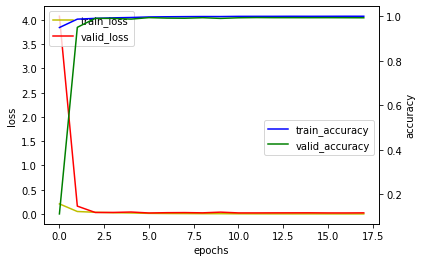

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='valid_loss')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='valid_accuracy')
acc_ax.set_xlabel('epochs')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))

plt.show()


# Pretrained Model 사용

In [20]:
from tensorflow.keras.applications import VGG16
import numpy as np

In [21]:
train_images = train_images.reshape(-1,784)
valid_images = valid_images.reshape(-1,784)

print(train_images.shape,valid_images.shape)

(60000, 784) (8500, 784)


In [22]:
test_images = test_images.reshape(-1,784)

np.dstack
- 스택을 쌓는 기능
- 채널이 추가됨

In [23]:
train_images = np.dstack([train_images]*3)
valid_images = np.dstack([valid_images]*3)
test_images = np.dstack([test_images]*3)

In [24]:
print(train_images.shape,valid_images.shape,test_images.shape)

(60000, 784, 3) (8500, 784, 3) (1500, 784, 3)


In [25]:
# 채널 뻥튀기 후 이미지 사이즈로 reshape
train_images = train_images.reshape(-1,28,28,3)
valid_images = valid_images.reshape(-1,28,28,3)
test_images = test_images.reshape(-1,28,28,3)

In [26]:
print(train_images.shape,valid_images.shape,test_images.shape)

(60000, 28, 28, 3) (8500, 28, 28, 3) (1500, 28, 28, 3)


In [28]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# 이미지로 바꾼후 크기 확대(resize), 후 다시 어레이로 바꿔 리스트
train_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_images])
valid_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in valid_images])
test_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_images])

In [29]:
print(train_images.shape,valid_images.shape,test_images.shape)

(60000, 48, 48, 3) (8500, 48, 48, 3) (1500, 48, 48, 3)


In [32]:
# VGG
vgg_model = VGG16(weights='imagenet',include_top=False, input_shape=(48,48,3))
vgg_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [34]:
layer_dict = {layer.name : layer for layer in vgg_model.layers}
layer_dict
# 이 레이어를 다 썼다간 컴퓨터 터진다

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7f7cec908e50>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7f7dd0074b50>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7f7cec90fa10>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7f7cec90f6d0>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7f7cec9e2210>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7f7cec8cd610>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7f7cec8cc550>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7f7cec8de750>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7f7cec8d1290>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7f7cec8ea190>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7f7cec8eeb90>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7f7cec8ea590>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7f7cec7b03d0>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7f7cec7bb4d

In [35]:
x = layer_dict['block2_conv2'].output

# VGG에서 나온 아웃풋값을 새 모델의 인풋으로, pretrained 값 사용
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(256, activation = 'relu')(x) # output 값 256개
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax')(x) # 최종 output 10개

In [37]:
custom_model = Model(inputs=vgg_model.input, outputs = x) # 모델생성
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 64)        73792 

In [38]:
# 기존에 가져온 weight값 변화 안시키기 = static 방식

for layer in custom_model.layers[:7]:
    layer.trainable = False

In [39]:
custom_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/'
model_path = f"{MODEL_SAVE_FOLDER}mnist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, 
                                monitor='val_accuracy', 
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)

cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

!rm '/content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/'*

In [41]:
hist = custom_model.fit(train_images,train_labels, validation_data=(valid_images,valid_labels),
                        epochs=100, batch_size = 200,
                        callbacks=[cb_checkpoint,cb_early_stopping])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 3.9605 - accuracy: 0.7727
Epoch 1: val_accuracy improved from -inf to 0.95506, saving model to /content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/mnist-1-0.16235-0.95506.hdf5
300/300 [==============================] - 22s 69ms/step - loss: 3.9605 - accuracy: 0.7727 - val_loss: 0.1624 - val_accuracy: 0.9551
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.9086
Epoch 2: val_accuracy improved from 0.95506 to 0.96894, saving model to /content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/mnist-2-0.11228-0.96894.hdf5
300/300 [==============================] - 20s 66ms/step - loss: 0.3013 - accuracy: 0.9086 - val_loss: 0.1123 - val_accuracy: 0.9689
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9293
Epoch 3: val_accuracy improved from 0.96894 to 0.97212, saving model to /content/drive/MyDrive/2022-1/국비지원교

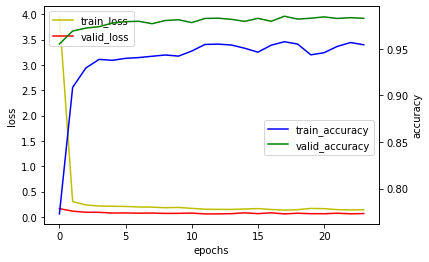

In [42]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='valid_loss')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='valid_accuracy')
acc_ax.set_xlabel('epochs')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))

plt.show()


In [43]:
!ls -la '/content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/'

total 109102
drwx------ 2 root root    4096 Mar  3 04:15 .ipynb_checkpoints
-rw------- 1 root root 9309328 Mar  4 06:38 mnist-10-0.06932-0.98106.hdf5
-rw------- 1 root root 9309328 Mar  4 06:35 mnist-1-0.16235-0.95506.hdf5
-rw------- 1 root root 9309328 Mar  4 06:39 mnist-12-0.05812-0.98247.hdf5
-rw------- 1 root root 9309328 Mar  4 06:39 mnist-13-0.05865-0.98271.hdf5
-rw------- 1 root root 9309328 Mar  4 06:41 mnist-18-0.05878-0.98482.hdf5
-rw------- 1 root root 9309328 Mar  4 06:36 mnist-2-0.11228-0.96894.hdf5
-rw------- 1 root root 9309328 Mar  4 06:36 mnist-3-0.09112-0.97212.hdf5
-rw------- 1 root root 9309328 Mar  4 06:36 mnist-4-0.08970-0.97365.hdf5
-rw------- 1 root root 9309328 Mar  4 06:37 mnist-5-0.07521-0.97753.hdf5
-rw------- 1 root root 9309328 Mar  4 06:37 mnist-6-0.07713-0.97906.hdf5
-rw------- 1 root root 9309328 Mar  4 06:37 mnist-7-0.07255-0.97941.hdf5
-rw------- 1 root root 9309328 Mar  4 06:38 mnist-9-0.06810-0.98024.hdf5


In [45]:
saved_path = "/content/drive/MyDrive/2022-1/국비지원교육/실습폴더/models/mnist-18-0.05878-0.98482.hdf5"
custom_model.load_weights(saved_path)

custom_model.evaluate(test_images, test_labels) #predict

47/47 [==============================] - 1s 15ms/step - loss: 0.0512 - accuracy: 0.9860


[0.05119439214468002, 0.9860000014305115]